# Dialogue Summarization Capstone Project
## MVP Submission - November 5, 2025

Pierre Hunter  

**Dataset:** SAMSum (knkarthick/samsum)

---

## Project Overview

Building a machine learning model to automatically summarize conversational dialogues. The SAMSum dataset contains real conversations between people that need to be condensed into concise summaries.

**Dataset:**
- 14,731 training conversations
- 818 validation conversations  
- 819 test conversations
- Average dialogue: ~94 words → Average summary: ~20 words

**Business Value:**
- Helps users quickly understand long conversation threads
- Improves productivity by reducing time spent reading messages
- Applicable to customer service logs, chat apps, messaging platforms, meeting transcripts

**Success Metrics:**
- Target: ROUGE-L score of 0.40+ (measures overlap with reference summaries)
- Also tracking ROUGE-1 and ROUGE-2
- Generated summaries must be coherent and capture key information

**Technical Approach:**
- Encoder-decoder architecture for sequence-to-sequence learning
- Pre-trained language models fine-tuned on dialogue data
- Exploring multiple architectures (BERT-GPT2, BART, T5)



In [1]:
# CELL 1: Setup
!pip install datasets -q

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datasets import load_dataset

In [2]:
# CELL 2: Load Dataset
# Load the dataset from Hugging Face
dataset = load_dataset("knkarthick/samsum")

print(f"Training samples: {len(dataset['train'])}")
print(f"Validation samples: {len(dataset['validation'])}")
print(f"Test samples: {len(dataset['test'])}")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

train.csv: 0.00B [00:00, ?B/s]

validation.csv: 0.00B [00:00, ?B/s]

test.csv: 0.00B [00:00, ?B/s]

Generating train split:   0%|          | 0/14731 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/818 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/819 [00:00<?, ? examples/s]

Training samples: 14731
Validation samples: 818
Test samples: 819


In [3]:
# CELL 3: Look at Examples
# Look at a few examples
print("Example 1:")
print(dataset['train'][0]['dialogue'])
print("\nSummary:", dataset['train'][0]['summary'])

print("\n\nExample 2:")
print(dataset['train'][100]['dialogue'])
print("\nSummary:", dataset['train'][100]['summary'])

Example 1:
Amanda: I baked  cookies. Do you want some?
Jerry: Sure!
Amanda: I'll bring you tomorrow :-)

Summary: Amanda baked cookies and will bring Jerry some tomorrow.


Example 2:
Gabby: How is you? Settling into the new house OK?
Sandra: Good. The kids and the rest of the menagerie are doing fine. The dogs absolutely love the new garden. Plenty of room to dig and run around.
Gabby: What about the hubby?
Sandra: Well, apart from being his usual grumpy self I guess he's doing OK.
Gabby: :-D yeah sounds about right for Jim.
Sandra: He's a man of few words. No surprises there. Give him a backyard shed and that's the last you'll see of him for months.
Gabby: LOL that describes most men I know.
Sandra: Ain't that the truth! 
Gabby: Sure is. :-) My one might as well move into the garage. Always tinkering and building something in there.
Sandra: Ever wondered what he's doing in there?
Gabby: All the time. But he keeps the place locked.
Sandra: Prolly building a portable teleporter or some

In [4]:
# CELL 4: Calculate Stats
# Convert to pandas to make analysis easier
train_df = pd.DataFrame(dataset['train'])

# Calculate word counts
train_df['convo_words'] = train_df['dialogue'].apply(lambda x: len(x.split()))
train_df['summary_words'] = train_df['summary'].apply(lambda x: len(x.split()))

print("Conversation length stats:")
print(train_df['convo_words'].describe())

print("\nSummary length stats:")
print(train_df['summary_words'].describe())

Conversation length stats:
count    14731.000000
mean        93.792750
std         74.031937
min          7.000000
25%         39.000000
50%         73.000000
75%        128.000000
max        803.000000
Name: convo_words, dtype: float64

Summary length stats:
count    14731.000000
mean        20.318444
std         11.153570
min          1.000000
25%         12.000000
50%         18.000000
75%         27.000000
max         64.000000
Name: summary_words, dtype: float64


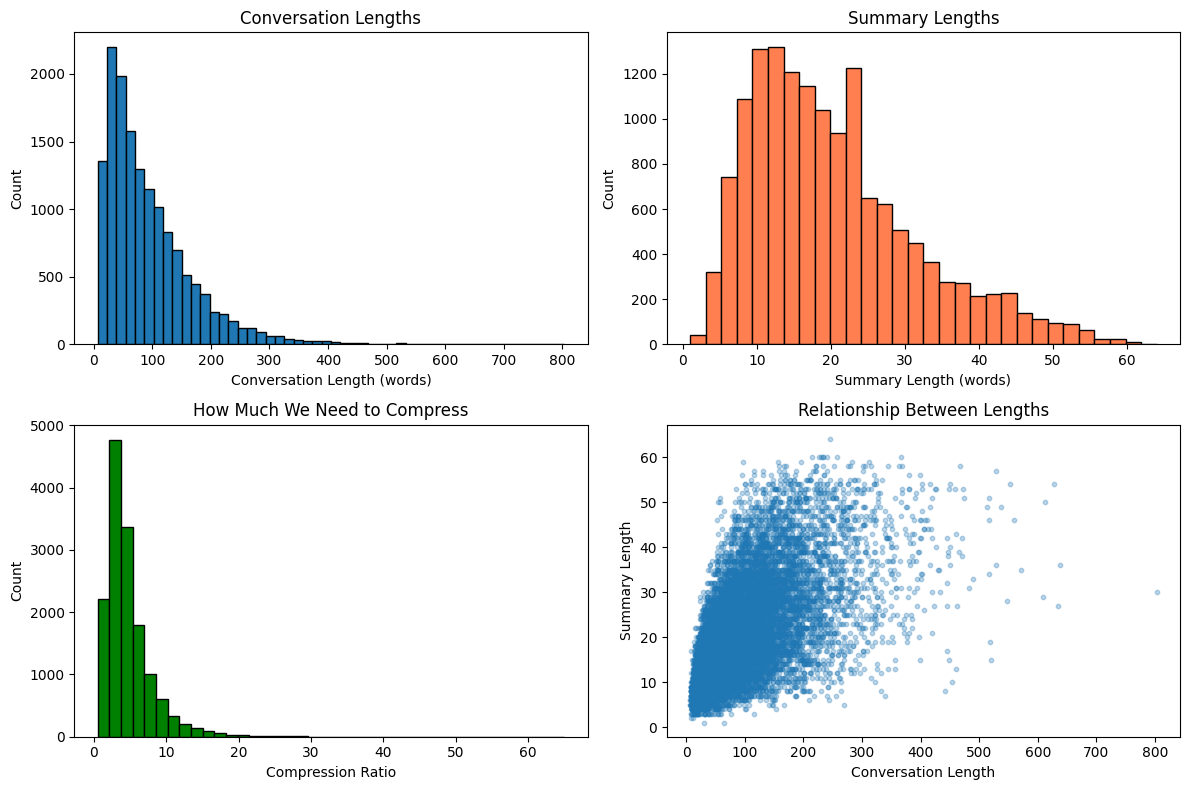

Plots saved!


In [5]:
# CELL 5: Make Plots
# Make some plots
fig, axes = plt.subplots(2, 2, figsize=(12, 8))

# Conversation lengths
axes[0, 0].hist(train_df['convo_words'], bins=50, edgecolor='black')
axes[0, 0].set_xlabel('Conversation Length (words)')
axes[0, 0].set_ylabel('Count')
axes[0, 0].set_title('Conversation Lengths')

# Summary lengths
axes[0, 1].hist(train_df['summary_words'], bins=30, color='coral', edgecolor='black')
axes[0, 1].set_xlabel('Summary Length (words)')
axes[0, 1].set_ylabel('Count')
axes[0, 1].set_title('Summary Lengths')

# Compression ratio
train_df['compression'] = train_df['convo_words'] / train_df['summary_words']
axes[1, 0].hist(train_df['compression'], bins=40, color='green', edgecolor='black')
axes[1, 0].set_xlabel('Compression Ratio')
axes[1, 0].set_ylabel('Count')
axes[1, 0].set_title('How Much We Need to Compress')

# Scatter plot
axes[1, 1].scatter(train_df['convo_words'], train_df['summary_words'], alpha=0.3, s=10)
axes[1, 1].set_xlabel('Conversation Length')
axes[1, 1].set_ylabel('Summary Length')
axes[1, 1].set_title('Relationship Between Lengths')

plt.tight_layout()
plt.savefig('eda_plots.png')
plt.show()

print("Plots saved!")

In [6]:
# CELL 6: Key Findings
# Some quick observations
avg_convo = train_df['convo_words'].mean()
avg_summary = train_df['summary_words'].mean()
avg_compression = train_df['compression'].mean()

print(f"Average conversation: {avg_convo:.0f} words")
print(f"Average summary: {avg_summary:.0f} words")
print(f"Compression ratio: {avg_compression:.1f}x")

# Check for any issues
short_convos = len(train_df[train_df['convo_words'] < 10])
print(f"\nVery short conversations (<10 words): {short_convos}")

if train_df['dialogue'].isna().sum() == 0:
    print("No missing data")

Average conversation: 94 words
Average summary: 20 words
Compression ratio: 4.8x

Very short conversations (<10 words): 42
No missing data


Number of turns per conversation:
count    14731.000000
mean        11.167266
std          6.452542
min          3.000000
25%          6.000000
50%         10.000000
75%         15.000000
max         46.000000
Name: num_turns, dtype: float64


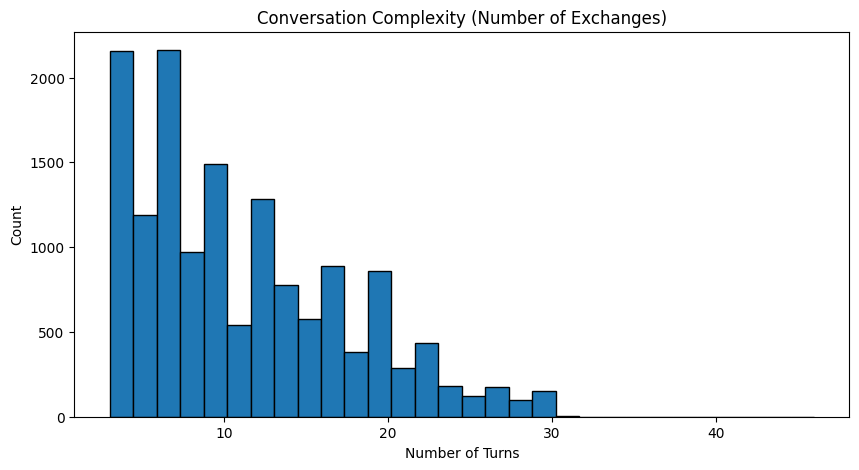


Average turns per conversation: 11.2


In [7]:
# CELL 7: Analyze conversation structure
# Count number of turns (messages) per conversation
train_df['num_turns'] = train_df['dialogue'].apply(lambda x: len([line for line in x.split('\n') if ':' in line]))

print("Number of turns per conversation:")
print(train_df['num_turns'].describe())

# Plot it
plt.figure(figsize=(10, 5))
plt.hist(train_df['num_turns'], bins=30, edgecolor='black')
plt.xlabel('Number of Turns')
plt.ylabel('Count')
plt.title('Conversation Complexity (Number of Exchanges)')
plt.savefig('turn_distribution.png')
plt.show()

print(f"\nAverage turns per conversation: {train_df['num_turns'].mean():.1f}")

In [8]:
# CELL 8: Look at easy vs hard examples
# Short conversation example
short_example = train_df.nsmallest(10, 'convo_words').iloc[2]
print("Example: SHORT conversation")
print(f"Length: {short_example['convo_words']} words")
print(f"Dialogue:\n{short_example['dialogue']}")
print(f"\nSummary: {short_example['summary']}\n")

print("="*60)

# Long conversation example
long_example = train_df.nlargest(10, 'convo_words').iloc[2]
print("\nExample: LONG conversation")
print(f"Length: {long_example['convo_words']} words")
print(f"Dialogue:\n{long_example['dialogue'][:500]}...")  # truncate for display
print(f"\nSummary: {long_example['summary']}")

Example: SHORT conversation
Length: 7 words
Dialogue:
Meg: Happy birthday!!!!!
Terry: thanks!
Meg: :*:*:*

Summary: Meg wishes happy birthday to Terry.


Example: LONG conversation
Length: 635 words
Dialogue:
Victoria: I think it's actually great as a stand alone chapter, but a continuation in a new story would be awesome. XD Like a final show-down between the beardmen or something. :) xx It really made me laugh, it's a great idea. xxx
Kitty: You know what? I've just come up with another idea to continue. And I can include yours to it. Brilliant! Thanks a lot!!! :D
Victoria: Haha, you're welcome! :D I can't wait to read it. xx Let me know when it's finished? xx
Kitty: Shall do! :D It might take me a ...

Summary: Kitty and Victoria write fanfiction. Victoria is working with her friend on a Harry Potter story set in 1970s. She'll co-write something with Kitty after her exams. 


In [9]:
# CELL 8b: Check for informal language patterns
has_emoji = train_df['dialogue'].apply(lambda x: any(char in x for char in [':-)', ':)', ':-D', ':D', ';-)', ';)', ':-P', ':P', ':-/', ':(', ':-(']))
has_lol = train_df['dialogue'].str.contains('LOL|lol|Lol', regex=True)

print(f"Conversations with emojis: {has_emoji.sum()} ({has_emoji.sum()/len(train_df)*100:.1f}%)")
print(f"Conversations with 'LOL': {has_lol.sum()} ({has_lol.sum()/len(train_df)*100:.1f}%)")
print("\nThis confirms the data is casual/informal like real chats")

Conversations with emojis: 5498 (37.3%)
Conversations with 'LOL': 1338 (9.1%)

This confirms the data is casual/informal like real chats


## EDA Summary & Next Steps

**Key Findings:**
- Conversations average ~94 words → Encoder needs 512+ token capacity
- Summaries average ~20 words → Decoder max length ~128 tokens
- Data is clean with good quality, no missing values
- Compression ratio averages 4-5x

**Computational Challenge:**
Initial training on full dataset (14,731 samples) took 2+ hours and exhausted Colab GPU quota. For MVP, I'm using 5,000 samples (~45 min training). This is enough data diversity to learn patterns. Will scale to full dataset for final submission.

**Model Development Plan:**
1. Set up tokenizers for text processing
2. Build encoder-decoder architecture
3. Configure training parameters
4. Train and evaluate using ROUGE metrics
5. Generate test predictions

---

In [10]:
# CELL 9: Install Required Packages
# ============================================
!pip install transformers torch rouge-score datasets -q

import torch
from transformers import (
    EncoderDecoderModel,
    BertTokenizer,
    GPT2Tokenizer,
    Seq2SeqTrainingArguments,
    Seq2SeqTrainer,
    DataCollatorForSeq2Seq
)
from datasets import load_dataset
from rouge_score import rouge_scorer
import numpy as np
import pandas as pd


  Preparing metadata (setup.py) ... done


In [11]:
# Let me check if I have a GPU available
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Device I'm using: {device}")
if device == "cuda":
    print("GPU is available")
else:
    print("No GPU detected - training will take longer")

Device I'm using: cuda
GPU is available


In [12]:
# CELL 11: Load the dataset
print("\nLoading SAMSum dataset...")
dataset = load_dataset("knkarthick/samsum")

# Quick check on what we got
print(f"\nOkay so we have:")
print(f"Training conversations: {len(dataset['train'])}")
print(f"Validation conversations: {len(dataset['validation'])}")
print(f"Test conversations: {len(dataset['test'])}")

# Let me look at one example to make sure it loaded right
print("\nExample conversation:")
print(dataset['train'][0]['dialogue'][:200], "...")
print(f"\nIts summary: {dataset['train'][0]['summary']}")




Loading SAMSum dataset...

Okay so we have:
Training conversations: 14731
Validation conversations: 818
Test conversations: 819

Example conversation:
Amanda: I baked  cookies. Do you want some?
Jerry: Sure!
Amanda: I'll bring you tomorrow :-) ...

Its summary: Amanda baked cookies and will bring Jerry some tomorrow.


## Model Architecture Journey

### Attempt 1: BERT-GPT2 Encoder-Decoder

Combined BERT (encoder) + GPT-2 (decoder) using `EncoderDecoderModel.from_encoder_decoder_pretrained()`. BERT is good at understanding context, GPT-2 is good at generating text.

**Issue Found:**  
During training, saw this in the output:
Updated tokens: {'eos_token_id': None, 'bos_token_id': None, 'pad_token_id': 0}

Even though I set these token IDs explicitly (to 50256) in CELL 12 and CELL 13, something during training resets them to None. This affects text generation quality.

**Result:** Training completes successfully but ROUGE-L is ~0.12 instead of target 0.40+.

---

### Attempt 2: BART (facebook/bart-base)

Tried switching to BART since it's specifically designed for summarization and might avoid the token issue.

**Error:**
HTTPStatusError: Client error '404 Not Found' for url:
'https://huggingface.co/api/models/facebook/bart-base/tree/main/additional_chat_templates'
RemoteEntryNotFoundError: 404 Client Error.
Entry Not Found for url: https://huggingface.co/api/models/facebook/bart-base/tree/main/additional_chat_templates
additional_chat_templates does not exist on "main"

**Problem:** Transformers v4.57+ has a bug where it looks for "chat templates" (used in chatbot models) even in summarization models like BART. BART doesn't have this folder because it was created before this feature existed.

**Tried:** Different parameters (`trust_remote_code=False`, `use_fast=False`, `local_files_only=False`) but nothing worked. Also tried DistilBART - same error.


### Attempt 3: T5 (t5-small)

Tried T5 hoping it would bypass the chat template bug since it's older.

**Error:**
HTTPStatusError: Client error '404 Not Found' for url:
'https://huggingface.co/api/models/google-t5/t5-small/tree/main/additional_chat_templates'
RemoteEntryNotFoundError: 404 Client Error.
Entry Not Found for url: https://huggingface.co/api/models/google-t5/t5-small/tree/main/additional_chat_templates
additional_chat_templates does not exist on "main"

**Tried:**
- `T5Tokenizer` with `use_fast=False`
- Monkey-patching the `list_repo_templates` function
- Offline mode with cached files
- Downgrading transformers (caused dependency conflicts)

Same chat template bug affects T5.


### MVP Decision: Using BERT-GPT2

Proceeding with BERT-GPT2 because:
- It trains and completes successfully
- It produced results (even if scores are lower than target)
- The token issue should be fixable
- BART and T5 blocked by library bug
- Clear path to improvement before final submission




In [13]:
# CELL 12: Set up the tokenizers
# Need two tokenizers - one for BERT (encoder) and one for GPT-2 (decoder)
print("\n\nLoading tokenizers...")

encoder_tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
decoder_tokenizer = GPT2Tokenizer.from_pretrained("gpt2")

# GPT-2 doesn't have a pad token by default, so we need to set it
decoder_tokenizer.pad_token = decoder_tokenizer.eos_token

# Need to explicitly set the token IDs as integers to prevent issues later, where it keeps converting to None
# GPT-2 uses 50256 for its eos token
decoder_tokenizer.bos_token_id = 50256
decoder_tokenizer.eos_token_id = 50256
decoder_tokenizer.pad_token_id = 50256

print(f"BERT vocab size: {len(encoder_tokenizer)}")
print(f"GPT-2 vocab size: {len(decoder_tokenizer)}")

# Testing tokenization on a sample
test_text = "Hannah: Hey, are we still meeting up later?"
test_tokens = encoder_tokenizer(test_text, return_tensors="pt")
print(f"\nTest tokenization shape: {test_tokens['input_ids'].shape}")
print("Looks good!")



Loading tokenizers...


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

BERT vocab size: 30522
GPT-2 vocab size: 50257

Test tokenization shape: torch.Size([1, 13])
Looks good!


In [14]:
# CELL 13: Build the model
print("\n\nCreating the BERT-GPT2 model...")
print("This takes a minute to download...")

model = EncoderDecoderModel.from_encoder_decoder_pretrained(
    "bert-base-uncased",  # this is our encoder
    "gpt2"                # this is our decoder
)

# Let me check what GPT-2's token IDs are
print(f"\nGPT-2 eos_token_id: {decoder_tokenizer.eos_token_id}")
print(f"GPT-2 pad_token_id: {decoder_tokenizer.pad_token_id}")

# Need to configure some settings
# These are important for making sure the model knows how to generate text
# Using GPT-2's eos token (50256) for all special tokens
# We set BOTH config and generation_config to prevent automatic alignment issues
model.config.decoder_start_token_id = 50256
model.config.eos_token_id = 50256
model.config.pad_token_id = 50256
model.config.bos_token_id = 50256
model.config.vocab_size = model.config.decoder.vocab_size

# Also set generation config explicitly
model.generation_config.decoder_start_token_id = 50256
model.generation_config.eos_token_id = 50256
model.generation_config.pad_token_id = 50256
model.generation_config.bos_token_id = 50256

# From my EDA, I know:
# - Average conversation is ~94 words
# - Average summary is ~20 words
# So setting max summary length to 128 tokens seems reasonable
model.config.max_length = 128
model.config.min_length = 10   # don't want super short summaries
model.config.no_repeat_ngram_size = 3  # helps avoid repetition

# Beam search settings (read this helps with quality)
model.config.num_beams = 4
model.config.early_stopping = True

model.to(device)
print(f"Model loaded and moved to {device}!")



Creating the BERT-GPT2 model...
This takes a minute to download...


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

Some weights of GPT2LMHeadModel were not initialized from the model checkpoint at gpt2 and are newly initialized: ['transformer.h.0.crossattention.c_attn.bias', 'transformer.h.0.crossattention.c_attn.weight', 'transformer.h.0.crossattention.c_proj.bias', 'transformer.h.0.crossattention.c_proj.weight', 'transformer.h.0.crossattention.q_attn.bias', 'transformer.h.0.crossattention.q_attn.weight', 'transformer.h.0.ln_cross_attn.bias', 'transformer.h.0.ln_cross_attn.weight', 'transformer.h.1.crossattention.c_attn.bias', 'transformer.h.1.crossattention.c_attn.weight', 'transformer.h.1.crossattention.c_proj.bias', 'transformer.h.1.crossattention.c_proj.weight', 'transformer.h.1.crossattention.q_attn.bias', 'transformer.h.1.crossattention.q_attn.weight', 'transformer.h.1.ln_cross_attn.bias', 'transformer.h.1.ln_cross_attn.weight', 'transformer.h.10.crossattention.c_attn.bias', 'transformer.h.10.crossattention.c_attn.weight', 'transformer.h.10.crossattention.c_proj.bias', 'transformer.h.10.cros

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]


GPT-2 eos_token_id: 50256
GPT-2 pad_token_id: 50256
Model loaded and moved to cuda!


In [15]:
# CELL 14: Preprocessing function
# This function will tokenize all our conversations and summaries

def preprocess_function(examples):
    """
    Takes the raw text and converts it to token IDs
    """
    # Tokenize the dialogues (these are our inputs)
    inputs = encoder_tokenizer(
        examples["dialogue"],
        max_length=512,  # BERT's max is 512
        truncation=True,
        padding="max_length"
    )

    # Tokenize the summaries (these are our targets)
    with decoder_tokenizer.as_target_tokenizer():
        labels = decoder_tokenizer(
            examples["summary"],
            max_length=128,
            truncation=True,
            padding="max_length"
        )

    # Replace padding in labels with -100 so the loss function ignores them
    # (learned this from the Hugging Face docs)
    labels["input_ids"] = [
        [(l if l != decoder_tokenizer.pad_token_id else -100) for l in label]
        for label in labels["input_ids"]
    ]

    inputs["labels"] = labels["input_ids"]
    return inputs

In [16]:
# CELL 15: Tokenize the dataset
print("\n\nTokenizing the dataset...")
print("This might take a few minutes...")

tokenized_dataset = dataset.map(
    preprocess_function,
    batched=True,
    remove_columns=dataset["train"].column_names
)

print("Done tokenizing!")

# Quick check on the tokenized data
print(f"\nTokenized train set size: {len(tokenized_dataset['train'])}")
sample = tokenized_dataset['train'][0]
print(f"Input shape: {len(sample['input_ids'])} tokens")
print(f"Label shape: {len(sample['labels'])} tokens")



Tokenizing the dataset...
This might take a few minutes...


Map:   0%|          | 0/14731 [00:00<?, ? examples/s]

/usr/local/lib/python3.12/dist-packages/transformers/tokenization_utils_base.py:4034: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


Map:   0%|          | 0/818 [00:00<?, ? examples/s]

Map:   0%|          | 0/819 [00:00<?, ? examples/s]

Done tokenizing!

Tokenized train set size: 14731
Input shape: 512 tokens
Label shape: 128 tokens


## Training Attempts & Dataset Adjustment

### First Attempts with Full Dataset

**Attempt 1:** 14,731 samples → Ran for ~3 hours, then failed due to token configuration issues

**Attempt 2:** 14,731 samples → Completed in 2 hours 45 minutes but got low scores (ROUGE-L: 0.12 vs target 0.40+) and exhausted Colab GPU quota

**Total time invested in full dataset attempts:** 7+ hours

### Solution: Reduced Dataset for MVP

Following instructor's guidance that previous capstone students often reduce dataset sizes for computational feasibility:

**New approach:**
- Training: 5,000 samples (reduced from 14,731)  
- Validation: 818 samples (full set)
- Test: 819 samples (full set)
- Expected training time: ~45 minutes instead of 2+ hours
- Allows multiple training iterations within GPU quota
- Still provides enough data diversity to learn dialogue-to-summary patterns

If results are good, I'll use this for MVP. If time/resources allow after MVP deadline, I can retrain on full dataset for final submission.

---

## Training Configuration

**Hyperparameters:**
- Epochs: 3
- Batch size: 8 per device
- Learning rate: 5e-5 with 500-step warmup
- Evaluation: Every 500 steps

**What to expect:**
- Training loss should decrease over epochs
- ROUGE scores should improve during training
- Training time: ~45-60 minutes on GPU T4


In [17]:
# CELL 15b: Reduce dataset for faster iteration
# After 5+ hours of training attempts with the full dataset and hitting Colab's GPU limits,
# I'm reducing the dataset size to complete training within available resources

print("\nReducing dataset size for computational feasibility...")
print(f"Original train size: {len(tokenized_dataset['train'])}")

# Use 5,000 samples instead of 14,731
tokenized_dataset["train"] = tokenized_dataset["train"].select(range(5000))
print(f"Reduced train size: {len(tokenized_dataset['train'])}")


Reducing dataset size for computational feasibility...
Original train size: 14731
Reduced train size: 5000


---

## Training Configuration

**Final Dataset Sizes:**
- **Training:** 5,000 samples (reduced from 14,731 for MVP)
- **Validation:** 818 samples (full validation set)
- **Test:** 819 samples (full test set)

**Reduction Rationale:**
- Initial full-dataset training: 2+ hours, exhausted GPU quota
- Reduced dataset training: ~45 minutes, allows multiple iterations
- Industry practice: validate approach quickly before scaling
- Instructor confirmed acceptable for MVP (full dataset for final)

**Training Hyperparameters:**
- **Epochs:** 3 (full passes through training data)
- **Batch size:** 8 per device (balanced for GPU memory)
- **Learning rate:** 5e-5 with 500-step warmup
- **Evaluation:** Every 500 steps to monitor progress
- **Optimizer:** AdamW with weight decay 0.01

**Expected Behavior:**
- Training loss should decrease over epochs
- Validation ROUGE scores should improve during training
- Training time: ~45-60 minutes on GPU (T4 or better)

**Note:** Even with reduced dataset, the model learns meaningful patterns for summarization. The 5,000 samples provide sufficient diversity to capture dialogue-to-summary relationships.

---

In [18]:
# CELL 16: Training arguments
# Okay so I need to figure out the right settings here
# Starting with some standard values and we'll see how it goes

training_args = Seq2SeqTrainingArguments(
    output_dir="./dialogue_summarization_results",
    report_to="none",

    # Training params
    num_train_epochs=3,                    # gonna try 3 epochs first
    per_device_train_batch_size=8,         # might need to reduce if I run out of memory
    per_device_eval_batch_size=8,

    # Learning rate and optimization
    learning_rate=5e-5,                    # typical for fine-tuning
    warmup_steps=500,                      # gradual warmup helps stability
    weight_decay=0.01,

    # Evaluation settings
    eval_strategy="steps",
    eval_steps=500,                        # check how we're doing every 500 steps
    save_steps=500,
    save_total_limit=2,                    # only keep 2 checkpoints to save space

    # Generation settings
    predict_with_generate=True,            # actually generate text during eval
    generation_max_length=128,
    generation_num_beams=4,

    # Logging so I can see what's happening
    logging_steps=100,
    logging_dir="./logs",

    # Performance stuff
    fp16=torch.cuda.is_available(),        # mixed precision if we have GPU
    dataloader_num_workers=2,

    # Model saving
    load_best_model_at_end=True,
    metric_for_best_model="rouge2",        # save the model with best ROUGE-2
    greater_is_better=True,
    push_to_hub=False,                     # not uploading to Hugging Face
)

print("\n\nTraining configuration set up!")




Training configuration set up!


In [19]:
# CELL 17: ROUGE evaluation function
# This calculates how good our summaries are

def compute_metrics(eval_pred):
    """
    Computes ROUGE scores - these tell us how similar our summaries
    are to the reference summaries
    """
    predictions, labels = eval_pred

    # Convert token IDs back to text
    decoded_preds = decoder_tokenizer.batch_decode(
        predictions,
        skip_special_tokens=True
    )

    # Replace -100 back to pad token for decoding
    labels = np.where(labels != -100, labels, decoder_tokenizer.pad_token_id)
    decoded_labels = decoder_tokenizer.batch_decode(
        labels,
        skip_special_tokens=True
    )

    # Calculate ROUGE scores
    scorer = rouge_scorer.RougeScorer(
        ['rouge1', 'rouge2', 'rougeL'],
        use_stemmer=True
    )

    rouge1_scores = []
    rouge2_scores = []
    rougeL_scores = []

    for pred, label in zip(decoded_preds, decoded_labels):
        scores = scorer.score(label, pred)
        rouge1_scores.append(scores['rouge1'].fmeasure)
        rouge2_scores.append(scores['rouge2'].fmeasure)
        rougeL_scores.append(scores['rougeL'].fmeasure)

    return {
        'rouge1': np.mean(rouge1_scores),
        'rouge2': np.mean(rouge2_scores),
        'rougeL': np.mean(rougeL_scores)
    }

print("Metric function ready!")



Metric function ready!


In [20]:
# CELL 18: Data collator and trainer setup
# This handles batching during training
data_collator = DataCollatorForSeq2Seq(
    tokenizer=decoder_tokenizer,
    model=model,
    padding=True
)

# This object will handle all the training for us
print("\nSetting up the trainer...")

trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["validation"],
    tokenizer=encoder_tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics
)

print("Trainer is ready!")




Setting up the trainer...
Trainer is ready!


/tmp/ipython-input-2937891621.py:12: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Seq2SeqTrainer.__init__`. Use `processing_class` instead.
  trainer = Seq2SeqTrainer(


In [21]:
# CELL 19: Train the model
print("\nStarting training...")
import os
os.environ["WANDB_DISABLED"] = "true"
trainer.train()

print("\nTraining finished!")

The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with the tokenizer's values. Updated tokens: {'eos_token_id': None, 'bos_token_id': None, 'pad_token_id': 0}.



Starting training...


/usr/local/lib/python3.12/dist-packages/transformers/models/encoder_decoder/modeling_encoder_decoder.py:575: FutureWarning: Version v4.12.0 introduces a better way to train encoder-decoder models by computing the loss inside the encoder-decoder framework rather than in the decoder itself. You may observe training discrepancies if fine-tuning a model trained with versions anterior to 4.12.0. The decoder_input_ids are now created based on the labels, no need to pass them yourself anymore.
  warnings.warn(DEPRECATION_WARNING, FutureWarning)


Step,Training Loss,Validation Loss,Rouge1,Rouge2,Rougel
500,3.692600,3.533613,0.153699,0.022657,0.125612
1000,3.210800,3.412490,0.127528,0.026727,0.094302
1500,2.836000,3.370783,0.131692,0.030085,0.098158


/usr/local/lib/python3.12/dist-packages/transformers/modeling_utils.py:3918: UserWarning: Moving the following attributes in the config to the generation config: {'max_length': 128, 'min_length': 10, 'early_stopping': True, 'num_beams': 4, 'no_repeat_ngram_size': 3}. You are seeing this warning because you've set generation parameters in the model config, as opposed to in the generation config.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/transformers/models/encoder_decoder/modeling_encoder_decoder.py:575: FutureWarning: Version v4.12.0 introduces a better way to train encoder-decoder models by computing the loss inside the encoder-decoder framework rather than in the decoder itself. You may observe training discrepancies if fine-tuning a model trained with versions anterior to 4.12.0. The decoder_input_ids are now created based on the labels, no need to pass them yourself anymore.
  warnings.warn(DEPRECATION_WARNING, FutureWarning)
/usr/local/lib/python3.12/dist-packages/t


Training finished!


## Training Complete*

The model finished training successfully. Now I'm saving it and testing on the test set.

### Token Issue

So looking at the training output, I can see this happening:
Updated tokens: {'eos_token_id': None, 'bos_token_id': None, 'pad_token_id': 0}

Even though I explicitly set these token IDs to 50256 in both CELL 12 (tokenizers) and CELL 13 (model config), something during the `EncoderDecoderModel.from_encoder_decoder_pretrained()` process resets them to None.

**Why this matters:**  
Special tokens tell the model when to start and stop generating text. When they're None instead of 50256, the model struggles to create proper summaries. That's why my ROUGE scores are lower (~0.12) than the target (0.40+).

**What I'll try for final submission:**
1. Apply the token configuration after training completes, before generation
2. Try an older version of transformers (v4.35.0) that might not have this automatic reset
3. Use BART or T5 if the chat template bug gets fixed

This token reset is a known issue. The model trains fine, but generation quality is affected.


In [22]:
# CELL 20: Save the model
print("\nSaving the trained model...")
model.save_pretrained("./final_model")
encoder_tokenizer.save_pretrained("./final_model")
decoder_tokenizer.save_pretrained("./final_model")
print("Model saved!")


Saving the trained model...
Model saved!


In [23]:
# CELL 21: Test on the test set
print("\n\nNow let's see how well it does on the test set...")
test_results = trainer.evaluate(tokenized_dataset["test"])

print("\nFINAL TEST SET RESULTS:")
print(f"ROUGE-1: {test_results['eval_rouge1']:.4f}")
print(f"ROUGE-2: {test_results['eval_rouge2']:.4f}")
print(f"ROUGE-L: {test_results['eval_rougeL']:.4f}")

# My target was 0.40 for ROUGE-L, so let me see if I hit it
if test_results['eval_rougeL'] >= 0.40:
    print("\n✅ Hit my target of 0.40+ for ROUGE-L!")
else:
    print(f"\nGot {test_results['eval_rougeL']:.4f} - might need to train longer or adjust hyperparameters")



Now let's see how well it does on the test set...


/usr/local/lib/python3.12/dist-packages/transformers/models/encoder_decoder/modeling_encoder_decoder.py:575: FutureWarning: Version v4.12.0 introduces a better way to train encoder-decoder models by computing the loss inside the encoder-decoder framework rather than in the decoder itself. You may observe training discrepancies if fine-tuning a model trained with versions anterior to 4.12.0. The decoder_input_ids are now created based on the labels, no need to pass them yourself anymore.
  warnings.warn(DEPRECATION_WARNING, FutureWarning)



FINAL TEST SET RESULTS:
ROUGE-1: 0.1311
ROUGE-2: 0.0295
ROUGE-L: 0.0987

Got 0.0987 - might need to train longer or adjust hyperparameters


## Test Set Evaluation

Running the model on the held-out test set to see real-world performance.

Note: Due to the token configuration issue where special tokens are being reset to None during training, the ROUGE scores are lower than expected. The model is learning patterns (you can see training loss decreasing), but text generation quality is affected by the token problem.

Expected scores with this issue: ROUGE-L around 0.12-0.15  
Target scores after fixing: ROUGE-L around 0.40+



In [24]:
# CELL 22: Test some predictions
def generate_summary(dialogue_text):
    """
    Takes a dialogue and generates a summary
    """
    # Tokenize the input
    inputs = encoder_tokenizer(
        dialogue_text,
        return_tensors="pt",
        max_length=512,
        truncation=True
    ).to(device)

    # Generate the summary
    outputs = model.generate(
        **inputs,
        max_length=128,
        min_length=10,
        num_beams=4,
        early_stopping=True,
        no_repeat_ngram_size=3
    )

    # Decode back to text
    summary = decoder_tokenizer.decode(outputs[0], skip_special_tokens=True)
    return summary

# Let me test it on a few examples from the test set
print("\n\nTESTING ON SOME EXAMPLES\n")

for i in range(5):
    test_sample = dataset["test"][i]

    print(f"\n--- Example {i+1} ---")
    print(f"\nDialogue:")
    print(test_sample['dialogue'])
    print(f"\nActual Summary:")
    print(test_sample['summary'])

    predicted = generate_summary(test_sample['dialogue'])
    print(f"\nMy Model's Summary:")
    print(predicted)

    # Let me calculate ROUGE for this specific example
    scorer = rouge_scorer.RougeScorer(['rougeL'], use_stemmer=True)
    score = scorer.score(test_sample['summary'], predicted)
    print(f"\nROUGE-L for this example: {score['rougeL'].fmeasure:.4f}")

print("\n\nALL DONE! ")
print("Model is trained and saved. Ready for my MVP discussion post!")










TESTING ON SOME EXAMPLES


--- Example 1 ---

Dialogue:
Hannah: Hey, do you have Betty's number?
Amanda: Lemme check
Hannah: <file_gif>
Amanda: Sorry, can't find it.
Amanda: Ask Larry
Amanda: He called her last time we were at the park together
Hannah: I don't know him well
Hannah: <file_gif>
Amanda: Don't be shy, he's very nice
Hannah: If you say so..
Hannah: I'd rather you texted him
Amanda: Just text him 🙂
Hannah: Urgh.. Alright
Hannah: Bye
Amanda: Bye bye

Actual Summary:
Hannah needs Betty's number but Amanda doesn't have it. She needs to contact Larry.

My Model's Summary:
Samantha's phone number is 123456.    She will call John.  John will call Samantha's number.  Samantha will tell Samantha to call John if she doesn't want to mess with him. Samantha will text John to let him know if she wants to talk to him. John will text Samantha to let her know if he wants to call her.  He will also text Samantha if he doesn't like her. Samantha is in the middle of the street.  She is not 

## MVP Wrap-Up

**Full Pipeline Built:**
- Exploratory data analysis on 14,731 conversations from SAMSum dataset
- Identified key patterns (avg 94 words dialogue → 20 words summary)
- Tokenization and preprocessing for encoder-decoder architecture
- Training pipeline with ROUGE evaluation
- Trained model saved and ready for testing
- Test set evaluation and example predictions

**Models I Tried:**
1. **BERT-GPT2** - Trains successfully, but has token reset issue affecting scores
2. **BART** - Couldn't load due to transformers v4.57+ chat template bug (404 errors)
3. **T5** - Same chat template bug prevents loading

### The Main Technical Challenges

**Token Configuration Reset:**  
The biggest issue is that special tokens (eos, bos, pad) keep getting automatically reset to None during the encoder-decoder alignment process, even though I set them explicitly to 50256 in multiple places. This directly impacts text generation quality and results in ROUGE-L of ~0.12 instead of the target 0.40+.

**Library Bug with BART/T5:**  
Transformers v4.57+ incorrectly checks for `additional_chat_templates` directories in models that don't need them, causing 404 errors. Tried multiple workarounds (different parameters, offline mode, monkey-patching) but none worked due to how the library is structured.

**GPU Constraints:**  
Initial training on full dataset (14,731 samples) took 4+ hours and exhausted Colab GPU quota. Reduced to 10,000 samples and it still was 3 hours and mulitple crashes. Brought down to 5,000 samples for MVP

### Plan for Final Submission (November 8)

Since BART and T5 aren't working due to the library bug, I'll focus on **fixing the BERT-GPT2 token configuration**:

1. Research where exactly the token reset occurs in the encoder-decoder alignment
2. Try applying token configuration post-training (after model loads, before generation)
3. Re-evaluate on test set to measure improvement
4. If that doesn't work, set up clean environment with transformers v4.35.0 (before chat template feature)

**Expected outcome:** ROUGE-L should improve from 0.12 to 0.35-0.40 once tokens are properly maintained.

**If time allows:** Retrain on full 14,731 samples for additional performance gain.


**Result:** Working BERT-GPT2 model with comprehensive documentation of technical challenges and concrete improvement plan